In [38]:
import RNA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display
import seaborn as sns

from collections import Counter
from collections import defaultdict
import subprocess
import difflib
import sys
import os
import random
import string
import time

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath



In [39]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # no scientific notation

# import feature_generation
from features import ij_distance, new_move_dist, plt_moves, config_distance, balance_in_all_things, return_shift_moves
from process_features import fp_call, find_moves, process

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
sequence = 'AGGUGUUAUAAAAGUGCAGAGCCAAGUCACCGCCUUGCCGUCGCUUCCGCUAUGCCUCAAAAGCGGAAUAUCGAGCGAGCGAUUGUGAUUCGAAUGGUCG'
s1       = '.(((................))).((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))..........'
s2       = '...(((.........)))..((((((((((.(((((((((....(((((((.(......).)))))))...)).))))).).).))))))....))))..'

search_width = 60
# search_width = 500

s = s1

sw = 2
fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
result = fp.get_en()/100.0
path = fp.get_path()


add_moves        = set()
delete_moves     = set()
available_add    = set()
available_delete = set()

en_contrib = []

for e, tup in enumerate(path):
    i = tup[0]
    j = tup[1]
    if i<0:
        delete_moves.add((i,j))
    if i>0:
        add_moves.add((i,j))

## we are evaluating 1 node = 1 structure
## means we are evaluating ALL moves (i, j) and see if we can find any patterns

##np.mean(en_contrib) ## mean of energies
##np.std(en_contrib) ## diversity of energies


## verhaeltnis delete add moves bezogen auf accessible moves
## mean of energy
## how many add / delete moves are currently available?
## if len(available_delete)/len(delete_moves) is high, the probability
## of making a wrong decision is probably quite high. 

## -------
## true values for classifier:
## - percentage of moves which lead to the optimal result?
## - sort by energy, where is the first contribution which leads to the optimal result? 
## - look at top energy contributions: how long do we have to postpone them to get the optimal result? 


fc = RNA.fold_compound(sequence)
pt = list(RNA.ptable(s))
pt1 = list(RNA.ptable(s1))
pt2 = list(RNA.ptable(s2))

for pos, (i,j) in enumerate(find_moves(pt, pt2)):  
    if (i,j) in add_moves:
        available_add.add((i,j))
    if (i,j) in delete_moves:
        available_delete.add((i,j))
    
    # map energies somehow to [0,1] such that the network will understand.  
    en = np.interp(fc.eval_move_pt(pt, i, j)/100, [-10,10], [0,1]) 
    en_contrib.append(en)

available_add, available_delete, len(available_add)/len(add_moves), len(available_delete)/len(delete_moves)

# np.std(en_contrib)

({(5, 17), (6, 16), (24, 95), (32, 83)},
 {(-43, -72),
  (-42, -73),
  (-41, -74),
  (-40, -76),
  (-39, -77),
  (-38, -79),
  (-37, -80),
  (-36, -81),
  (-35, -82),
  (-4, -21),
  (-3, -22),
  (-2, -23)},
 0.25,
 1.0)

In [4]:
# [   0,    0 ] .(((................))).((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))..........  -23.10 0.125
# [  -4,  -21 ] .((..................)).((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))..........  -20.70 0.1875
# [  -3,  -22 ] .(....................).((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))..........  -17.70 0.0
# [  -2,  -23 ] ........................((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))..........  -21.90 0.05882
# [  23,   96 ] ......................(.((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..)))))).....)....  -18.10 0.0
# [  22,   97 ] .....................((.((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..)))))).....))...  -21.00 0.0
# [  24,   95 ] .....................(((((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))....)))...  -23.60 0.0
# [  21,   98 ] ....................((((((((((....(((((((((.(((((((.(......).)))))))...))).)).))))..))))))....))))..  -25.20 0.07692
# [ -35,  -82 ] ....................((((((((((.....((((((((.(((((((.(......).)))))))...))).)).)))...))))))....))))..  -23.60 0.08333
# [ -36,  -81 ] ....................((((((((((......(((((((.(((((((.(......).)))))))...))).)).))....))))))....))))..  -22.70 0.1667
# [ -37,  -80 ] ....................((((((((((.......((((((.(((((((.(......).)))))))...))).)).).....))))))....))))..  -19.10 0.0
# [ -38,  -79 ] ....................((((((((((........(((((.(((((((.(......).)))))))...))).)).......))))))....))))..  -20.00 0.1667
# [ -39,  -77 ] ....................((((((((((.........((((.(((((((.(......).)))))))...))).)........))))))....))))..  -17.40 0.0
# [ -40,  -76 ] ....................((((((((((..........(((.(((((((.(......).)))))))...)))..........))))))....))))..  -19.70 0.0
# [  32,   83 ] ....................((((((((((.(........(((.(((((((.(......).)))))))...)))........).))))))....))))..  -18.10 0.0
# [  33,   81 ] ....................((((((((((.((.......(((.(((((((.(......).)))))))...)))......).).))))))....))))..  -17.10 0.0
# [  34,   79 ] ....................((((((((((.(((......(((.(((((((.(......).)))))))...)))....).).).))))))....))))..  -16.30 0.0
# [  35,   78 ] ....................((((((((((.((((.....(((.(((((((.(......).)))))))...)))...)).).).))))))....))))..  -17.90 0.0
# [  36,   77 ] ....................((((((((((.(((((....(((.(((((((.(......).)))))))...)))..))).).).))))))....))))..  -19.50 0.0
# [  37,   76 ] ....................((((((((((.((((((...(((.(((((((.(......).)))))))...))).)))).).).))))))....))))..  -21.50 0.0
# [  38,   75 ] ....................((((((((((.(((((((..(((.(((((((.(......).)))))))...)))))))).).).))))))....))))..  -24.60 0.0
# [ -41,  -74 ] ....................((((((((((.(((((((...((.(((((((.(......).)))))))...)).))))).).).))))))....))))..  -23.20 0.0
# [ -42,  -73 ] ....................((((((((((.(((((((....(.(((((((.(......).)))))))...)..))))).).).))))))....))))..  -19.90 0.0
# [ -43,  -72 ] ....................((((((((((.(((((((......(((((((.(......).)))))))......))))).).).))))))....))))..  -22.70 0.0
# [  39,   73 ] ....................((((((((((.((((((((.....(((((((.(......).)))))))....).))))).).).))))))....))))..  -21.90 0.0
# [  40,   72 ] ....................((((((((((.(((((((((....(((((((.(......).)))))))...)).))))).).).))))))....))))..  -25.20 0.0
# [   5,   17 ] ....(...........)...((((((((((.(((((((((....(((((((.(......).)))))))...)).))))).).).))))))....))))..  -21.20 0.0
# [   6,   16 ] ....((.........))...((((((((((.(((((((((....(((((((.(......).)))))))...)).))))).).).))))))....))))..  -23.70 0.0

In [4]:
def adjust_pt(pt, i, j):
    pt_adj = pt.copy()
    if i<0:
        pt_adj[-i] = 0
        pt_adj[-j] = 0
    else:
        pt_adj[i] = j
        pt_adj[j] = i
    return pt_adj

In [5]:
reloaded_model = tf.keras.models.load_model('dnn_model')

data = {'en_mean': [0.678000],
        'en_std': 0.0328022,
        'best_en': 0.625,
        # 'vic': 0,
        # 'vic_best': 0,
        # 'unique_moves': 1,
        # 'distlast': 0.130
        }
test_features = pd.DataFrame.from_dict(data)


y = reloaded_model.predict(test_features)[0][0]

y

0.2565853

In [6]:


moves = [(-78, -90, 80), (-80, -89, 90), (-5, -51, 130), (-58, -71, 170), (-61, -68, 170), (-8, -48, 230), (-76, -92, 250), (-75, -96, 270), (-72, -99, 300), (-60, -69, 420), (-6, -50, 500), (-73, -98, 500), (-59, -70, 620), (-77, -91, 620), (-7, -49, 640), (-74, -97, 640)]
moves = [(52, 90, 360), (47, 95, 510), (51, 91, 600), (50, 92, 610), (49, 93, 620), (48, 94, 650), (46, 96, 680)]

moves = np.array([(abs(i[0]), abs(i[1])) for i in moves])

# X = np.array([[1, 2], [2, 2], [2, 3],
            #   [8, 7], [8, 8], [25, 80]])

clustering = DBSCAN(eps=2, min_samples=1).fit(moves)

for i in range(len(moves)):
    print (moves[i], clustering.labels_[i])

len(set(clustering.labels_))

[52 90] 0
[47 95] 0
[51 91] 0
[50 92] 0
[49 93] 0
[48 94] 0
[46 96] 0


1

In [41]:
sequence = 'CCUCUUGGCAAGGAACUGUUGUAUGACGGUACGUAACGCGCGCCAGAGCUCAAGAUUCAAACGGCGGCUUCAGAACUCAGUCAGGCGAAGAAGCCAGCAC'
s1       = '.......((.(.(.((((((....)))))).).)...))........................((((((((....((......))....)))))).))..'
s2       = '.(((.((((..(..((((((....)))))).).........)))))))...............((((((((....((......))....)))))).))..'

# sequence = 'GAGACCGAUACGAUUAAGCCAGAAUUCCAAUGAUUUGGGGAUCGGGGCUGUUUAGUCUCGUUUAAUCCCGGCGAUGUCUGGGUCAUAUUGUCCGUUAACC' 
# s1       = '(.((.(((((.(((....(((((..(((((....)))(((..(((((((....)))))))......)))...))..)))))))).)))))))).......'
# s2       = '.((((.((.((.....((((.((.((((((....)))))).))..)))).....)).))))))...(((((......)))))..................'

sequence = 'GACUGCCUCAAUUUCCACUUCGCCACAAUGUGAGGUCUCAUUCAACUGCCGCUCAUAAUGGUCGGUCAAUGAGGUCCAUCCGGUCCCUCCAGCCUGGCUA'
s1       = '.....................((((...((..((..((((((..((((((.........)).)))).))))))............).).))...))))..'
s2       = '.....................((((...((.((((.((...(((...((((((......)).))))...)))((.....)))).)).))))...))))..'

# 417
sequence = "AACGGGGGCUUCAACUCGCUCAGAAUCAGCGGUAUAGAUAUCCGGGUAGCGGCUUAAAGCAGCACUUUACCAUCGAGGGGGCAAGGAACACUAGCCGACU"
s1       = "..((((....((...(((((.......)))))....))..))))(((((.(.(........)..).)))))....((..(((.((.....)).)))..))"
s2       = "..((((....((...(((((.......)))))....))..))))((((.(.((.....)).).....))))....((..(((.((.....)).)))..))"

sequence = "GCAUGUUUGGGCAGUCCCUGCGUCCGGUACUGCAUCGUUGCGCUCGGUGCACAUAUUAUGCCCCGGCCUCCUUUGCGAAACGAAGGUACAUUACACCUGG"
s1       = "....(((.(((((.....((((.((((...((((....)))).)))))))).......))))).)))..((((((.....)))))).............."
s2       = "(((...((((((((...))))..))))...))).(((((((((.(((.(((.......))).))))).......)))..))))((((.......)))).."

sequence = "GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU"
s1 = "...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))........."
s2 = "....(((..(((((........((.((((.....)))).))(((((........)))))..))))).)))(((((.(((....))))))))........."


In [36]:
# alternative 192
# 807 ! 809 13   417

filename_samples = f'./dataset_100_large.csv'
# filename_samples = f'./dataset_200_large.csv'

samples_df = pd.read_csv(filename_samples)
for index, row in samples_df.iterrows():
    if index != 214:
        continue
    sequence = row.sequence
    s1 = row.s1
    s2 = row.s2


In [44]:
print(f"sequence = \"{sequence}\"")
print(f"s1 = \"{s1}\"")
print(f"s2 = \"{s2}\"")
print (RNA.bp_distance(s1, s2))

# s1 = "..................................................................((((((.(.......).))))))..........."
# s2 = "...(((.(.(.((((..((((((...((((........((((.......)))).........))))..))))))..)).))).).)))............"

# sw = 20.1
sw = 10
# sw = 0.1
fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=True)
result = fp.get_en()/100.0
path = fp.get_path()

# path = [(0, 0, -2330), (-80, -91, -2170), (-81, -90, -1880), (-82, -89, -2120), (-13, -62, -1940), (-12, -63, -2100), (-4, -75, -1750), (-5, -74, -1730), (-6, -73, -1640), (-7, -72, -1500), (-8, -71, -1500), (-10, -69, -1170), (-11, -68, -1620), (74, 81, -1290), (75, 80, -1600), (4, 11, -1320), (-15, -59, -1300), (3, 12, -1490), (5, 10, -1630), (-16, -58, -1250), (-17, -57, -1020), (-18, -56, -870), (-19, -55, -770), (-20, -54, -900), (17, 97, -490), (18, 96, -780), (19, 95, -900), (16, 98, -1040), (15, 99, -1140), (-21, -52, -790), (21, 94, -710), (-24, -49, -540), (-22, -51, -790), (-25, -48, -690), (24, 91, -460), (25, 90, -610), (-26, -47, -370), (-27, -46, -370), (26, 89, -650), (27, 88, -850), (28, 87, -980), (-34, -39, -770), (-30, -43, -640), (-33, -40, -470), (-31, -42, -430), (-32, -41, -465), (38, 66, -370), (37, 67, -480), (29, 86, -820), (46, 54, -420), (36, 68, -630), (45, 55, -810), (39, 61, -640), (47, 53, -710), (40, 60, -810), (42, 58, -900), (44, 56, -1050), (41, 59, -1660)]
# path = [(0, 0, -2330), (-80, -91, -2170), (-81, -90, -1880), (-82, -89, -2120), (-13, -62, -1940), (-12, -63, -2100), (-4, -75, -1750), (-5, -74, -1730), (-6, -73, -1640), (-7, -72, -1500), (-8, -71, -1500), (-10, -69, -1170), (-11, -68, -1620), (74, 81, -1290), (75, 80, -1600), (4, 11, -1320), (-15, -59, -1300), (3, 12, -1490), (5, 10, -1630), (-16, -58, -1250), (-17, -57, -1020), (-18, -56, -870), (-19, -55, -770), (-20, -54, -900), (17, 97, -490), (18, 96, -780), (19, 95, -900), (16, 98, -1040), (15, 99, -1140), (-21, -52, -790), (21, 94, -710), (-24, -49, -540), (-22, -51, -790), (-25, -48, -690), (24, 91, -460), (25, 90, -610), (-26, -47, -370), (-27, -46, -370), (26, 89, -650), (27, 88, -850), (28, 87, -980), (-30, -43, -640), (-34, -39, -770), (-33, -40, -470), (-31, -42, -430), (-32, -41, -465), (38, 66, -370), (37, 67, -480), (29, 86, -820), (46, 54, -420), (36, 68, -630), (45, 55, -810), (39, 61, -640), (47, 53, -710), (40, 60, -810), (42, 58, -900), (44, 56, -1050), (41, 59, -1660)]
# path = [(0, 0, -11.9), (-55, -67, -10.7), (-56, -66, -9.7), (-57, -65, -8.8), (-58, -64, -13.2), (-72, -99, -11.8), (-73, -98, -8.0), (-74, -97, -9.5), (-76, -94, -8.2), (-13, -38, -7.5), (13, 40, -8.8), (-77, -93, -7.6), (-78, -92, -6.6), (-79, -91, -7.0), (-82, -87, -6.0), (-80, -89, -4.9), (-81, -88, -7.8), (74, 86, -5.1), (72, 88, -4.7), (71, 89, -5.7), (-14, -37, -4.7), (69, 91, -4.9), (70, 90, -10.7), (-8, -45, -8.4), (3, 45, -4.5), (2, 46, -8.0), (-15, -36, -5.4), (-16, -35, -7.9)]

print_moves(sequence, s1, s2, path, convert_to_float=True)

sequence = "GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU"
s1 = "...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))........."
s2 = "....(((..(((((........((.((((.....)))).))(((((........)))))..))))).)))(((((.(((....))))))))........."
38
GAAAUGGUCCUACUCCGUAGCUUAAUGAUCCGAAGUCAGUAUCUGAUACACUCUUCAGGCCGGUAGCCCACAUCGCGCAGCCUUGUCGAUGAUCCACGCU
[   0,    0 ] ...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -16.10
[  -4,  -18 ] ....(((.......)))..(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -14.30
[  -7,  -15 ] ....((.........))..(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -10.50
[  -5,  -17 ] .....(.........)...(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........  -10.50
[  -6,  -16 ] ...................(((...((..((((((...((((...))))...)))).)).

-7.2

In [45]:
# which nodes do we permutate first? in principle, this is a simlar concept as the findpath search width, where we just
# use the sw. to perform a look-ahead

## IDEA
# check how many moves out of all choices are net-negative. 

search_width_multiplier = 6



fc = RNA.fold_compound(sequence)
pt1 = list(RNA.ptable(s1))
pt2 = list(RNA.ptable(s2))

# for i,j in find_moves(pt1, pt2):    
#     pt = adjust_pt(pt1, i, j)
#     s = RNA.db_from_ptable(pt)
#     search_width = 1
#     sE, path = findpath_librna.pathfinder(sequence, s, s2, search_width=search_width, return_paths=True)
#     en = fc.eval_move_pt(pt1, i, j)
#     # print_moves(sequence, s, s2, path)
#     print (s, i, j, en, sE)


def next_vicinity(lastmove, avail_moves):

    """
    percentage of moves which can continue in the vicinity of the last move
    """
    lasti, lastj = lastmove
    moves = len(avail_moves)
    cntr = 0

    for a in avail_moves:
        i=a[0]
        j=a[1]      
        if lasti + 1 == i or lasti - 1 == i or\
           lastj + 1 == j or lastj - 1 == j:
           cntr += 1
    return cntr



# def last_vs_best(clustered_moves):
#     """
#     compare the last move with the currently best avaialble move
#     """
#     # print (lastmove, bestmove, clustered_moves)
#     # best index has index 0, last move has index -1
#     if clustered_moves[0] == clustered_moves[-1]:
#         return 1
#     else:
#         return 0


def last_vs_best(lastmove, bestmove, lensequence):
    lasti = abs(lastmove[0])
    lastj = abs(lastmove[1])
    i = abs(bestmove[0])
    j = abs(bestmove[1])
    dist = abs(lasti - i) + abs(lastj - j)
    return dist/(lensequence*2) #, dist, lensequence


def cluster_moves(inputmoves, absolute_values=False):
    """
    cluster moves with DBscan. needs to include the last move as well...
    """

    if absolute_values:
        m = [(abs(i[0]), abs(i[1])) for i in inputmoves]
        moves = np.array(m)
    else:
        m = [(i[0], i[1]) for i in inputmoves]
        moves = np.array(m)

    # print ("clustering", moves)
    clustering = DBSCAN(eps=2, min_samples=1).fit(moves)
    
    # generate clustering dict (move-tuple:label, ...)
    return {i[0]:i[1] for i in zip(m, clustering.labels_)}, clustering.labels_



# def structure_evaluation(sequence, s, s2):
def structure_evaluation(fc, pt1, pt2, path, lastmove):
    avail_moves = []
    fp_results = []
    en_contrib = []

    available_add = set()
    available_delete = set()
    lensequence = pt1[0]

    # pt1 = list(RNA.ptable(s))
    # pt2 = list(RNA.ptable(s2))
    for pos, (i,j) in enumerate(find_moves(pt1, pt2)):    
        next_en = fc.eval_move_pt(pt1, i, j)
        # mark where we found our move    
        # map energies somehow to [0,1] such that the network will understand.  
        en = np.interp(next_en/100, [-10,10], [0,1]) 
        en_contrib.append(en)
        avail_moves.append((i, j, next_en))

        if i>0:
            available_add.add((i,j))
        elif i<0:
            available_delete.add((i,j))

    if len(avail_moves)==0:
        add_delete = 0
    else:
        add_delete = len(available_delete)/len(avail_moves)

    # print ('best', en_contrib[0], 'avg', en_mean)

    avail_moves.sort(key=lambda x: x[2]) # best move at [0]


    vic = next_vicinity(lastmove, avail_moves)
    vic_best = next_vicinity(lastmove, avail_moves[0:1])

    avail_moves = [(i[0], i[1]) for i in avail_moves]
    avail_moves_abs = [(abs(i[0]), abs(i[1])) for i in avail_moves] # this is sorted as well, best move at [0]

    # absolute_moves+=[lastmove]
    # print ("avail+last", avail_moves)

    # last_index = -1
    # best_index = absolute_moves.index((abs(absolute_moves[0][0]), abs(absolute_moves[0][1])))
    # print ("best", best_index)

    p = [(0, 0)] + [(i[0], i[1]) for i in path]
    clustered_moves, _ = cluster_moves(p, absolute_values=False)
    clustered_moves_abs, _ = cluster_moves(p, absolute_values=True)

    bestmove = avail_moves[0]
    bestmove_abs = avail_moves_abs[0]

    lastmove_abs = abs(lastmove[0]), abs(lastmove[1])

    # last move vicinity is available, but not among the best energy options:

    unique_found = set()
    foundpos = -1
    for pos, m in enumerate(avail_moves):
        l = clustered_moves[m]
        if l == clustered_moves[lastmove]:
            foundpos = len(unique_found) # cant add pos here

        if l not in unique_found:
            unique_found.add(l)
    if foundpos == -1:
        foundpos = len(unique_found)
    foundpos /= len(unique_found)

    unique_found_abs = set()
    foundpos_abs = -1
    for pos, m in enumerate(avail_moves_abs):
        l = clustered_moves_abs[m]
        if l == clustered_moves_abs[lastmove_abs]:
            foundpos_abs = len(unique_found_abs) # cant add pos here

        if l not in unique_found_abs:
            unique_found_abs.add(l)
    if foundpos_abs == -1:
        foundpos_abs = len(unique_found_abs)
    foundpos_abs /= len(unique_found_abs)

    # print (foundpos, last_is_best, last_is_best_abs)
    # print ("bestmove", bestmove, clustered_moves[bestmove], bestmove_abs, clustered_moves_abs[bestmove_abs])
    # print ("lastmove", lastmove, clustered_moves[lastmove], lastmove_abs, clustered_moves_abs[lastmove_abs])

    # distlast = last_vs_best(clustered_moves)

    unique_labels = 1 / len(unique_found)
    # unique_moves = 1/unique_labels

    distlast = last_vs_best(lastmove, bestmove, lensequence)
    unique_moves = 0

    # print ("unique", unique_labels, unique_moves)

    count_available = len(avail_moves)/len(path)

    # print ("vicinity", vic, lastmove, "->", avail_moves)

    # print ('avail add', available_add)
    # print ('avail del', available_delete)

    for pos, (i,j) in enumerate(avail_moves):  
        pt = adjust_pt(pt1, i, j)
        snew = RNA.db_from_ptable(pt)
        # if i > 0:
        #     snew = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
        # if i < 0:
        #     snew = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]

        ptnew = list(RNA.ptable(snew))
        result_new, path = fp_call(sequence, snew, s2, search_width_multiplier)
        fp_results.append(result_new)

    if len(avail_moves) == 0:
        label = 0
        en_mean = 0
        en_std = 0
        best_en = 0


    else:
        label = np.argmin(fp_results)/len(fp_results)

        en_mean = np.mean(en_contrib)
        en_std = np.std(en_contrib)
        en_contrib.sort(key=lambda x: x)
        en_diff = en_contrib[0] / en_mean # best en, relative

        best_en = en_contrib[0]




    # print (avail_moves)
    # print (fp_results)
    # print (avail_moves, unique_moves)
    
    return label, en_mean, en_std, best_en, bestmove, foundpos, foundpos_abs, distlast, unique_labels

    # return label, en_mean, en_diff, avail_moves[0:3]

    return label, en_mean, en_diff, avail_moves[0:3], best_en

    print (fp_results)
    print (best_result)

# structure_evaluation(sequence, s, s2)
# structure_evaluation(sequence, pt1, pt2)

# generate path or not
# fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=sw, mp=False)
# result = fp.get_en()/100.0
# path = fp.get_path()


pt = pt1.copy()
lastmove = 0, 0
lastcount_available = 0

labels = []

for pos, (i, j, en) in enumerate(path):
    if i==0: 
        print (RNA.db_from_ptable(pt)[0:100])
        continue
    # if i not in random_moves:
    #     continue

    fc = RNA.fold_compound(sequence)
    label, en_mean, en_std, best_en, bestmove, foundpos, foundpos_abs, distlast, unique_labels = structure_evaluation(fc, pt, pt2, path[1:], lastmove)
    current_en = fc.eval_structure_pt(pt)/100


    # compare with prediction
    data = {'en_mean': [en_mean],
            'en_std': en_std,
            'best_en': best_en,
            # 'vic': vic,
            # 'vic_best': vic_best,
            # 'unique_moves': unique_moves,
            # 'distlast': distlast
            }
    test_features = pd.DataFrame.from_dict(data)  
    y = reloaded_model.predict(test_features)[0][0]
    pred_label = round(y,3)

    # display_count = lastcount_available - count_available
    pt = adjust_pt(pt, i, j)

    labels.append(label)
    foundpos = round(foundpos, 3)
    foundpos_abs = round(foundpos_abs, 3)
    en_mean = round(en_mean, 3)
    en_std = round(en_std, 3)
    best_en = round(best_en, 3)

    # print (RNA.db_from_ptable(pt)[0:100], current_en, 'label', round(label,4), 'pred', pred_label, (i,j), en_mean, en_std, best_en, foundpos, foundpos_abs, distlast, unique_labels)
    # print (f' {RNA.db_from_ptable(pt)[0:100]} {current_en:5} label: {label:6.3}, predicted:  {pred_label:6.3}, move: {(i,j)}')
    print (f' {RNA.db_from_ptable(pt)[0:100]} {current_en:5} l:{label:6.3}, p:{pred_label:6.3}, m:{(i,j), bestmove} {en_mean, en_std, best_en, foundpos, foundpos_abs, distlast,}')
    
    lastmove = i, j
    # lastcount_available = count_available

    # ptlast = pt

    # if pos == 5:
    #     break


print (labels)

# print_moves(sequence, s1, s2, path)


# while loop - increase sw from 1 onwards until we find the optimal path. how easy is the next decision?

# distance of best move in relation to last move
# moves left in vicinity, which are not the best moves. 
# !! consider number of avail moves / +before difference comparison...

## todo: focus on really "difficult" nodes - prediction quality?
## todo2: true labels: normalize en, not position

# todo3: new cluster available?


...((((.......)))).(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....)))))))).........
 ....(((.......)))..(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))......... -16.1 l: 0.105, p: 0.158, m:((-4, -18), (-42, -46)) (0.678, 0.071, 0.54, 1.0, 1.0, 0.44)
 ....((.........))..(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))......... -14.3 l:   0.0, p: 0.027, m:((-7, -15), (-5, -17)) (0.671, 0.081, 0.5, 1.0, 1.0, 0.01)
 .....(.........)...(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))......... -10.5 l:   0.0, p: 0.014, m:((-5, -17), (-5, -17)) (0.661, 0.078, 0.5, 0.667, 0.667, 0.02)
 ...................(((...((..((((((...((((...))))...)))).)).))..)))...(((((.(((....))))))))......... -10.5 l:   0.0, p:  -0.0, m:((-6, -16), (-6, -16)) (0.661, 0.111, 0.33, 0.0, 0.0, 0.01)
 ......(............(((...((..((((((...((((...))))...)))).)).))..))))..(((((.(((....))))))))......... -13.9 l: 0.778, p: 0.095, m:((7, 6

In [257]:
# sE, path = fp_call(sequence, s1, s2, search_width_multiplier)
# print_moves(sequence, s1, s2, path)

In [258]:
# filename_samples = f'./dataset_100_large.csv'
# samples_df = pd.read_csv(filename_samples)
# sequence = ''
# s1 = ''
# s2 = ''
# search_width_multiplier = 6

# df = pd.DataFrame()
# all_results = []

# for index, row in samples_df.iterrows():
#     # if index != 90:
#     #     continue


#     sequence = row.sequence
#     s1 = row.s1
#     s2 = row.s2


#     bp_dist = RNA.bp_distance(s1, s2)

#     print (index)
#     print (sequence)
#     print (s1)
#     print (s2)
#     print (bp_dist)

#     # random_move = random.choice(range(bp_dist))

#     fc = RNA.fold_compound(sequence)
#     pt1 = list(RNA.ptable(s1))
#     pt2 = list(RNA.ptable(s2))
#     # structure_evaluation(sequence, pt1, pt2)

#     # sE, path = fp_call(sequence, s1, s2, search_width_multiplier)
#     fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, mp=False)
#     sE = fp.get_en()/100.0
#     path = fp.get_path()

#     # print (path)

#     p = [(0, 0)] + [(i[0], i[1]) for i in path]
#     clustered_moves, _ = cluster_moves(p, absolute_values=False)
#     clustered_moves_abs, _ = cluster_moves(p, absolute_values=True)

#     print (clustered_moves)

#     random_moves = random.choices([i[0] for i in path], k=3)
#     # print (random_moves)
#     # print (len(path))

#     ptlast = list(RNA.ptable(s1))
#     pt = list(RNA.ptable(s1))

#     lastmove = 0, 0

#     all_evals = 0
#     results = []

#     # find a random structure in the path
#     # ignore the last moves, we're not interested in meaningless decisions
#     for i, j, en in path:
#         if i==0: 
#             continue
#         # if i not in random_moves:
#         #     continue

#         # print (i, RNA.db_from_ptable(pt))

#         if i in random_moves:
#             label, en_mean, en_std, best_en, foundpos, foundpos_abs, distlast, unique_labels = structure_evaluation(fc, pt, pt2, path, lastmove)
            
#             # pred label with old data
#             data = {'en_mean': [en_mean],
#             'en_std': en_std,
#             'best_en': best_en,
#             # 'vic': vic,
#             # 'vic_best': vic_best,
#             # 'unique_moves': unique_moves,
#             # 'distlast': distlast
#             }
#             test_features = pd.DataFrame.from_dict(data)  
#             y = reloaded_model.predict(test_features)[0][0]
#             pred_label = round(y,4)
            
            
#             results.append((sequence, RNA.db_from_ptable(pt), s2, i, pred_label, label, en_mean, en_std, best_en, foundpos, foundpos_abs, distlast, unique_labels))
#             all_evals += label       
#             # print (i, eval)  

#         pt = adjust_pt(ptlast, i, j)

#         lastmove = i, j
#         ptlast = pt

#     if all_evals != 0:
#         all_results += results


#     # break

#     if index%10 == 0:        
#         print (index, end=" ")
#         # print (all_results)
#         df = pd.DataFrame(all_results, columns=['sequence', 's', 's2', 'i', 'j', 'target', 'en_mean', 'en_std', 'best_en', 'foundpos', 'foundpos_abs', 'distlast', 'unique_labels'])# .set_index('sequence')
#         filename = f'./move_diversity4.csv'
#         df.to_csv(filename)

#     if index == 10:
#         break



## validate model

In [298]:
def plot_confusion_matrix(cfmatrix):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    # sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6)) 
    plt.title("Confusion Matrix") 
    sns.set(font_scale=1.4) 

    group_names = ['True Neg','False Pos','False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cfmatrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cfmatrix.flatten()/np.sum(cfmatrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cfmatrix, annot=labels, fmt='', cmap='Blues')

In [302]:
filename = "dataset_results2.csv"
df = pd.read_csv(filename)


In [309]:
truelabels = df["labels"]
predlabels = df["prediction"]

cutoff = 0.0002
cutoff = 0.01

truepos   = np.where((predlabels>cutoff) & (truelabels > 0))
trueneg   = np.where((predlabels<=cutoff) & (truelabels == 0))
falseneg  = np.where((predlabels<=cutoff) & (truelabels > 0))
falsepos  = np.where((predlabels>cutoff) & (truelabels == 0))

# df[falseneg]
# df[df.index.isin(list(falseneg[0]))]

truepos   = len(truepos[0])
trueneg   = len(trueneg[0])
falseneg  = len(falseneg[0]) # type 2, overestimation
falsepos  = len(falsepos[0]) # false positive (FP) eqv. with false alarm, type I error or underestimation



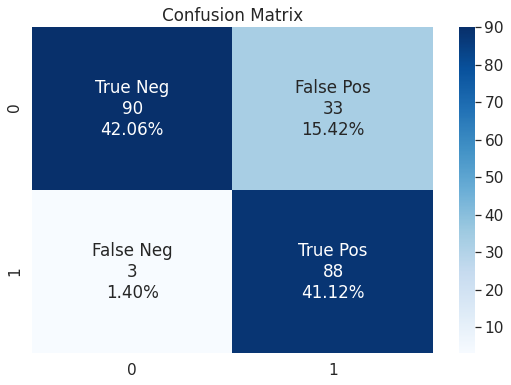

In [310]:
confmatrix = np.array([[trueneg,  falsepos], [ falseneg, truepos]])
plot_confusion_matrix(confmatrix)

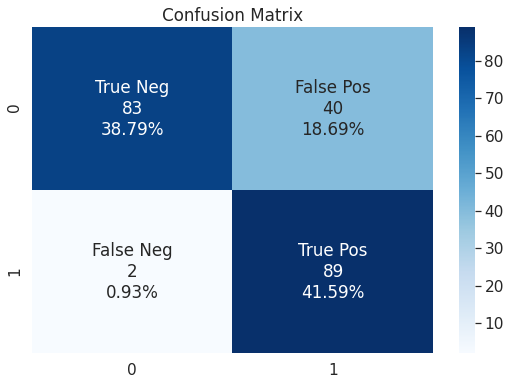

In [297]:
confmatrix = np.array([[trueneg,  falsepos], [ falseneg, truepos]])
plot_confusion_matrix(confmatrix)

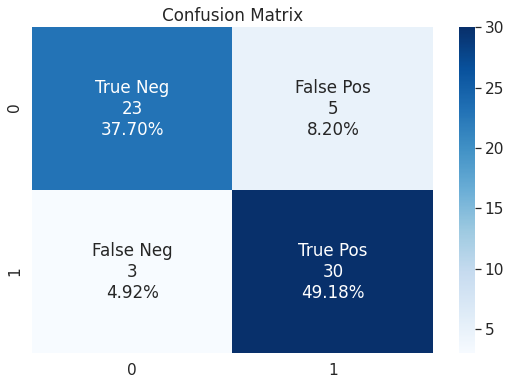

In [262]:


    # plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    # plt.close()

test = np.array([[23,  5], [ 3, 30]])
plot_confusion_matrix(test)

In [311]:
from sklearn.metrics import matthews_corrcoef

y_true = [+1, +1, +1, -1]
y_pred = [+1, -1, +1, +1]

matthews_corrcoef(y_true, y_pred)

-0.3333333333333333